In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
# Make sure the file name matches the one you uploaded.
try:
    df = pd.read_csv('Telco-Customer-Churn.csv')
except FileNotFoundError:
    print("File not found. Please ensure 'WA_Fn-UseC_-Telco-Customer-Churn.csv' is uploaded to Colab and the name is correct.")

if 'df' in locals(): # Check if df was loaded successfully
    print("Dataset loaded successfully!")
    print("First 5 rows of the dataset:")
    print(df.head())
    print("\n--------------------------------------------------\n")

    print("Information about the dataset:")
    df.info()
    print("\n--------------------------------------------------\n")

    print("Descriptive statistics for numerical columns:")
    print(df.describe())
    print("\n--------------------------------------------------\n")

    print("Number of unique values in each column:")
    for column in df.columns:
        print(f"Column '{column}': {df[column].nunique()} unique values")
    print("\n--------------------------------------------------\n")

    print("Value counts for the target variable 'Churn':")
    if 'Churn' in df.columns:
        print(df['Churn'].value_counts())
    else:
        print("Target variable 'Churn' not found. Please check column names.")

Dataset loaded successfully!
First 5 rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  Te

In [ ]:
# Make a copy of the DataFrame to keep the original intact (good practice)
df_cleaned = df.copy()

# 1. Handle 'TotalCharges'
# Convert 'TotalCharges' to numeric. Errors='coerce' will turn non-convertible values into NaN.
df_cleaned['TotalCharges'] = pd.to_numeric(df_cleaned['TotalCharges'], errors='coerce')

# Check for missing values created after conversion
print("Missing values in 'TotalCharges' after conversion:")
print(df_cleaned['TotalCharges'].isnull().sum())

# Let's see the rows where TotalCharges is NaN
print("\nRows where TotalCharges is NaN:")
print(df_cleaned[df_cleaned['TotalCharges'].isnull()][['tenure', 'MonthlyCharges', 'TotalCharges']])

# Decision: For customers with 0 tenure, TotalCharges might be legitimately 0 or missing.
# If TotalCharges is NaN and tenure is 0, it's likely they are new customers with no charges yet.
# Let's impute these NaN values with 0.
# For any other NaN in TotalCharges (if tenure is not 0), we might need a different strategy,
# but let's check the common case first.
df_cleaned.loc[(df_cleaned['TotalCharges'].isnull()) & (df_cleaned['tenure'] == 0), 'TotalCharges'] = 0

# Verify if all NaNs in TotalCharges are handled (especially those linked to tenure == 0)
print("\nMissing values in 'TotalCharges' after imputation (for tenure=0 cases):")
print(df_cleaned['TotalCharges'].isnull().sum())

# If there are still NaNs, we'll need to decide how to handle them (e.g., median imputation or removal)
# For now, let's assume the common scenario where tenure=0 explains these NaNs.
# If any NaNs remain, we can impute with the median for simplicity in this step.
if df_cleaned['TotalCharges'].isnull().sum() > 0:
    print(f"\nStill {df_cleaned['TotalCharges'].isnull().sum()} NaNs remaining in TotalCharges. Imputing with median.")
    median_total_charges = df_cleaned['TotalCharges'].median()
    df_cleaned['TotalCharges'].fillna(median_total_charges, inplace=True)
    print("Missing values in 'TotalCharges' after median imputation:")
    print(df_cleaned['TotalCharges'].isnull().sum())


# 2. Drop 'customerID'
if 'customerID' in df_cleaned.columns:
    df_cleaned.drop('customerID', axis=1, inplace=True)
    print("\n'customerID' column dropped.")
else:
    print("\n'customerID' column not found or already dropped.")

# 3. Convert 'Churn' (target variable) to numeric (0 and 1)
# It's good practice to do this early for consistency.
if 'Churn' in df_cleaned.columns:
    df_cleaned['Churn'] = df_cleaned['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
    print("\n'Churn' column converted to numeric (1 for Yes, 0 for No).")
    print("Value counts for the numeric 'Churn' variable:")
    print(df_cleaned['Churn'].value_counts())
else:
    print("\n'Churn' column not found.")


# Display info to see changes
print("\n--------------------------------------------------\n")
print("Information about the dataset after cleaning 'TotalCharges' and dropping 'customerID':")
df_cleaned.info()

print("\n--------------------------------------------------\n")
print("Descriptive statistics now including 'TotalCharges':")
# Include all dtypes to see stats for TotalCharges now
print(df_cleaned.describe(include='all'))

Missing values in 'TotalCharges' after conversion:
11

Rows where TotalCharges is NaN:
      tenure  MonthlyCharges  TotalCharges
488        0           52.55           NaN
753        0           20.25           NaN
936        0           80.85           NaN
1082       0           25.75           NaN
1340       0           56.05           NaN
3331       0           19.85           NaN
3826       0           25.35           NaN
4380       0           20.00           NaN
5218       0           19.70           NaN
6670       0           73.35           NaN
6754       0           61.90           NaN

Missing values in 'TotalCharges' after imputation (for tenure=0 cases):
0

'customerID' column dropped.

'Churn' column converted to numeric (1 for Yes, 0 for No).
Value counts for the numeric 'Churn' variable:
Churn
0    5174
1    1869
Name: count, dtype: int64

--------------------------------------------------

Information about the dataset after cleaning 'TotalCharges' and dropping 'custom

In [ ]:
# Identify categorical columns (excluding SeniorCitizen which is already 0/1, and Churn which is our target)
# We look for columns with 'object' dtype.
categorical_cols = df_cleaned.select_dtypes(include='object').columns
print(f"Categorical columns to be one-hot encoded: {list(categorical_cols)}")

# Perform one-hot encoding using pandas get_dummies()
# drop_first=True helps in reducing multicollinearity by removing one redundant column for each feature.
# For example, for 'gender' (Male/Female), it will create one column 'gender_Male' (1 if Male, 0 if Female).
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

print("\n--------------------------------------------------\n")
print("Shape of the DataFrame before encoding:", df_cleaned.shape)
print("Shape of the DataFrame after one-hot encoding:", df_encoded.shape)
print("\n--------------------------------------------------\n")

print("First 5 rows of the encoded DataFrame:")
print(df_encoded.head())
print("\n--------------------------------------------------\n")

print("Information about the encoded DataFrame:")
df_encoded.info()
print("\n--------------------------------------------------\n")

print("Check for any remaining object columns (should be none except potentially an index name):")
print(df_encoded.select_dtypes(include='object').columns)

Categorical columns to be one-hot encoded: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

--------------------------------------------------

Shape of the DataFrame before encoding: (7043, 20)
Shape of the DataFrame after one-hot encoding: (7043, 31)

--------------------------------------------------

First 5 rows of the encoded DataFrame:
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0        False   
1              0      34           56.95       1889.50      0         True   
2              0       2           53.85        108.15      1         True   
3              0      45           42.30       1840.75      0         True   
4              0       2           70.70        151.65      1        Fals

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# The fully encoded DataFrame is df_encoded

# 1. Separate features (X) and target (y)
if 'Churn' in df_encoded.columns:
    X = df_encoded.drop('Churn', axis=1)
    y = df_encoded['Churn']
    print("Features (X) and target (y) separated.")
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)
else:
    print("Error: 'Churn' column not found in df_encoded. Please check previous steps.")
    # Stop execution or handle error if Churn is missing

if 'X' in locals() and 'y' in locals(): # Proceed only if X and y are defined
    # 2. Split data into training and testing sets
    # We'll use 80% for training and 20% for testing.
    # random_state ensures reproducibility of the split.
    # stratify=y is important for imbalanced datasets to ensure that both train and test sets
    # have a similar proportion of the target variable classes.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\nData split into training and testing sets:")
    print("Shape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
    print("Churn distribution in y_train:\n", y_train.value_counts(normalize=True))
    print("Churn distribution in y_test:\n", y_test.value_counts(normalize=True))

    # 3. Feature Scaling
    # Identify numerical columns that need scaling (already numeric, not the dummy variables)
    # In our df_encoded, these are 'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'.
    # SeniorCitizen is already 0/1, so scaling it isn't strictly necessary but won't harm.
    # The dummy variables (True/False or 0/1) also don't need scaling.
    numerical_cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
    # We can also include 'SeniorCitizen' if we want, but it is already 0/1. Let's stick to continuous ones for now.

    scaler = StandardScaler()

    # Fit the scaler on the training data's numerical columns and transform them
    X_train[numerical_cols_to_scale] = scaler.fit_transform(X_train[numerical_cols_to_scale])

    # Use the SAME fitted scaler to transform the test data's numerical columns
    # DO NOT fit the scaler on X_test, as this would be data leakage.
    X_test[numerical_cols_to_scale] = scaler.transform(X_test[numerical_cols_to_scale])

    print("\n--------------------------------------------------\n")
    print("Numerical features scaled using StandardScaler.")
    print("First 5 rows of scaled X_train (showing only scaled columns for brevity):")
    print(X_train[numerical_cols_to_scale].head())
    print("\nFirst 5 rows of scaled X_test (showing only scaled columns for brevity):")
    print(X_test[numerical_cols_to_scale].head())

    print("\nDescriptive statistics of scaled 'tenure' in X_train (should have mean ~0, std ~1):")
    print(X_train['tenure'].describe())

Features (X) and target (y) separated.
Shape of X: (7043, 30)
Shape of y: (7043,)

Data split into training and testing sets:
Shape of X_train: (5634, 30)
Shape of X_test: (1409, 30)
Shape of y_train: (5634,)
Shape of y_test: (1409,)
Churn distribution in y_train:
 Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Churn distribution in y_test:
 Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64

--------------------------------------------------

Numerical features scaled using StandardScaler.
First 5 rows of scaled X_train (showing only scaled columns for brevity):
        tenure  MonthlyCharges  TotalCharges
3738  0.102371       -0.521976     -0.262257
3151 -0.711743        0.337478     -0.503635
4860 -0.793155       -0.809013     -0.749883
3867 -0.263980        0.284384     -0.172722
3810 -1.281624       -0.676279     -0.989374

First 5 rows of scaled X_test (showing only scaled columns for brevity):
        tenure  MonthlyCharges  TotalCharges
437  

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the models
# random_state is set for reproducibility of Random Forest results
log_reg_model = LogisticRegression(solver='liblinear', random_state=42)
rf_model = RandomForestClassifier(random_state=42) # Using default n_estimators=100

# --- Logistic Regression ---
print("--- Training Logistic Regression Model ---")
log_reg_model.fit(X_train, y_train)
print("Logistic Regression model trained successfully.")

# Make predictions on the training set (optional, to see training accuracy)
# y_train_pred_lr = log_reg_model.predict(X_train)
# print(f"Logistic Regression Training Accuracy: {accuracy_score(y_train, y_train_pred_lr):.4f}")


# --- Random Forest Classifier ---
print("\n--- Training Random Forest Model ---")
rf_model.fit(X_train, y_train)
print("Random Forest model trained successfully.")

# Make predictions on the training set (optional, to see training accuracy)
# y_train_pred_rf = rf_model.predict(X_train)
# print(f"Random Forest Training Accuracy: {accuracy_score(y_train, y_train_pred_rf):.4f}")

print("\nBoth models have been trained!")

--- Training Logistic Regression Model ---
Logistic Regression model trained successfully.

--- Training Random Forest Model ---
Random Forest model trained successfully.

Both models have been trained!


--- Logistic Regression Model Evaluation ---
Accuracy: 0.8041

Confusion Matrix:
[[925 110]
 [166 208]]

Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.85      0.89      0.87      1035
   Churn (1)       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.74      1409
weighted avg       0.80      0.80      0.80      1409



--- Random Forest Model Evaluation ---
Accuracy: 0.7850

Confusion Matrix:
[[921 114]
 [189 185]]

Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.83      0.89      0.86      1035
   Churn (1)       0.62      0.49      0.55       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.78      1409



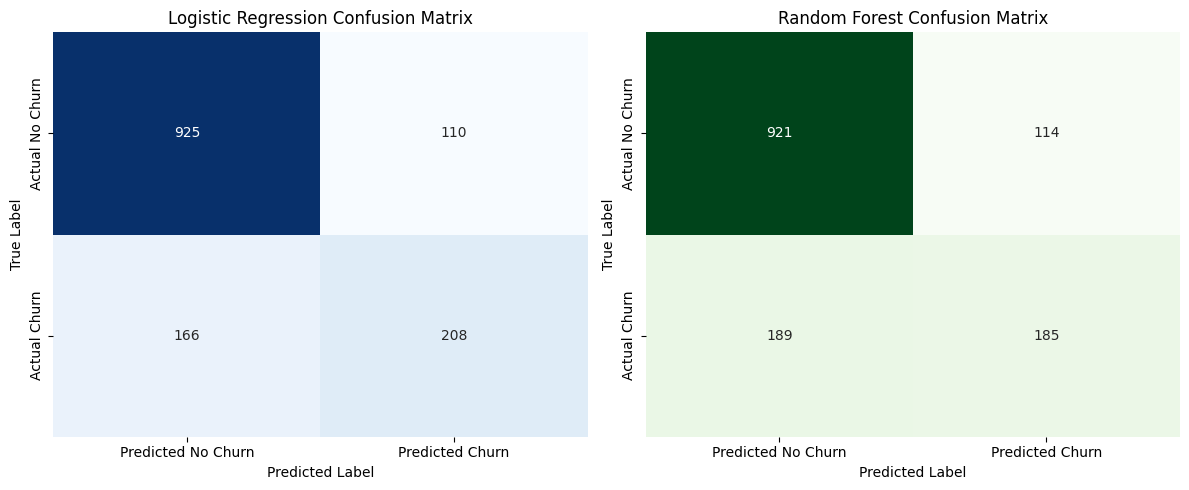


--- Summary of Accuracies ---
Logistic Regression Test Accuracy: 0.8041
Random Forest Test Accuracy: 0.7850


In [ ]:
# --- Evaluate Logistic Regression Model ---
print("--- Logistic Regression Model Evaluation ---")
y_pred_lr = log_reg_model.predict(X_test)

# Accuracy
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {lr_accuracy:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Churn (0)', 'Churn (1)']))

# --- Evaluate Random Forest Model ---
print("\n\n--- Random Forest Model Evaluation ---")
y_pred_rf = rf_model.predict(X_test)

# Accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {rf_accuracy:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No Churn (0)', 'Churn (1)']))

# --- Visualizing Confusion Matrices ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

print("\n--- Summary of Accuracies ---")
print(f"Logistic Regression Test Accuracy: {lr_accuracy:.4f}")
print(f"Random Forest Test Accuracy: {rf_accuracy:.4f}")

--- Training Logistic Regression with class_weight='balanced' ---

--- Logistic Regression (Balanced) Evaluation ---
Accuracy: 0.7381

Confusion Matrix:
[[747 288]
 [ 81 293]]

Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.90      0.72      0.80      1035
   Churn (1)       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



--- Training Random Forest with class_weight='balanced' ---

--- Random Forest (Balanced) Evaluation ---
Accuracy: 0.7899

Confusion Matrix:
[[929 106]
 [190 184]]

Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.83      0.90      0.86      1035
   Churn (1)       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted av

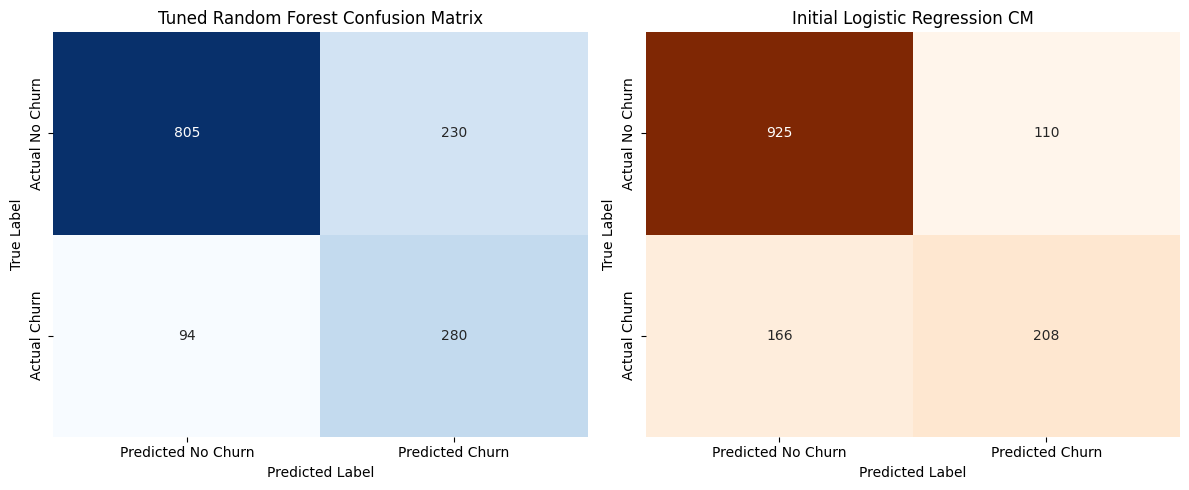

In [ ]:
from sklearn.model_selection import GridSearchCV

# --- 1. Retrain Logistic Regression with class_weight='balanced' ---
print("--- Training Logistic Regression with class_weight='balanced' ---")
log_reg_balanced = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
log_reg_balanced.fit(X_train, y_train)
y_pred_lr_balanced = log_reg_balanced.predict(X_test)

print("\n--- Logistic Regression (Balanced) Evaluation ---")
lr_balanced_accuracy = accuracy_score(y_test, y_pred_lr_balanced)
print(f"Accuracy: {lr_balanced_accuracy:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_balanced))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_balanced, target_names=['No Churn (0)', 'Churn (1)']))

# --- 2. Retrain Random Forest with class_weight='balanced' (as a quick improvement) ---
print("\n\n--- Training Random Forest with class_weight='balanced' ---")
rf_balanced = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_balanced.fit(X_train, y_train)
y_pred_rf_balanced = rf_balanced.predict(X_test)

print("\n--- Random Forest (Balanced) Evaluation ---")
rf_balanced_accuracy = accuracy_score(y_test, y_pred_rf_balanced)
print(f"Accuracy: {rf_balanced_accuracy:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_balanced))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_balanced, target_names=['No Churn (0)', 'Churn (1)']))


# --- 3. Hyperparameter Tuning for Random Forest (can take a bit longer) ---
print("\n\n--- Hyperparameter Tuning for Random Forest using GridSearchCV ---")
# Define a smaller parameter grid for speed in this example
# You can expand this grid for a more thorough search
param_grid_rf = {
    'n_estimators': [100, 200], # Number of trees
    'max_depth': [10, 20, None],    # Max depth of trees
    'min_samples_split': [2, 5], # Min samples to split a node
    'min_samples_leaf': [1, 2],   # Min samples in a leaf node
    'class_weight': ['balanced', None] # Also try without explicit balancing if grid searching other params
}

# Initialize GridSearchCV
# cv=3 means 3-fold cross-validation.
# scoring='f1' focuses on F1-score for the positive class (Churn=1) by default if binary, or specify 'f1_weighted' etc.
# Or we can use 'recall_weighted' or make a custom scorer for recall of class 1.
# For churn, recall of the positive class is often critical. Let's use 'recall' for class 1 (churn).
# To be precise, use make_scorer with recall_score and pos_label=1
from sklearn.metrics import make_scorer, recall_score
recall_scorer_churn = make_scorer(recall_score, pos_label=1)

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid_rf,
                              cv=3, # Using 3 folds for quicker execution
                              scoring=recall_scorer_churn, # Focus on recall for the churn class
                              verbose=1, # Shows progress
                              n_jobs=-1) # Use all available CPU cores

grid_search_rf.fit(X_train, y_train)

print("\nBest parameters found for Random Forest:", grid_search_rf.best_params_)
best_rf_model = grid_search_rf.best_estimator_ # This is the best model found

# Evaluate the best Random Forest model from GridSearchCV
y_pred_rf_tuned = best_rf_model.predict(X_test)

print("\n--- Tuned Random Forest Model Evaluation ---")
rf_tuned_accuracy = accuracy_score(y_test, y_pred_rf_tuned)
print(f"Accuracy: {rf_tuned_accuracy:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_tuned, target_names=['No Churn (0)', 'Churn (1)']))


# --- Final Summary of Accuracies (including improved models) ---
print("\n--- Summary of Accuracies ---")
print(f"Initial Logistic Regression Test Accuracy: {lr_accuracy:.4f}")
print(f"Balanced Logistic Regression Test Accuracy: {lr_balanced_accuracy:.4f} (Recall for Churn: {recall_score(y_test, y_pred_lr_balanced, pos_label=1):.4f})")
print(f"Initial Random Forest Test Accuracy: {rf_accuracy:.4f}")
print(f"Balanced Random Forest Test Accuracy: {rf_balanced_accuracy:.4f} (Recall for Churn: {recall_score(y_test, y_pred_rf_balanced, pos_label=1):.4f})")
print(f"Tuned Random Forest Test Accuracy: {rf_tuned_accuracy:.4f} (Recall for Churn: {recall_score(y_test, y_pred_rf_tuned, pos_label=1):.4f})")

# Visualizing Confusion Matrix for the best model (e.g., tuned RF or balanced LR)
plt.figure(figsize=(12, 5))
final_best_model_predictions = y_pred_rf_tuned # Change this if LR balanced is better
final_best_model_cm = confusion_matrix(y_test, final_best_model_predictions)
final_best_model_name = "Tuned Random Forest" # Change accordingly

if lr_balanced_accuracy > rf_tuned_accuracy and recall_score(y_test, y_pred_lr_balanced, pos_label=1) > recall_score(y_test, y_pred_rf_tuned, pos_label=1):
    final_best_model_predictions = y_pred_lr_balanced
    final_best_model_cm = confusion_matrix(y_test, final_best_model_predictions)
    final_best_model_name = "Balanced Logistic Regression"


plt.subplot(1, 2, 1)
sns.heatmap(final_best_model_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title(f'{final_best_model_name} Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Compare with initial LR
plt.subplot(1, 2, 2)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Initial Logistic Regression CM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.tight_layout()
plt.show()



--- Top 15 Feature Importances from Tuned Random Forest ---
                                 feature  importance
1                                 tenure    0.174399
3                           TotalCharges    0.141446
2                         MonthlyCharges    0.106475
25                     Contract_Two year    0.103149
10           InternetService_Fiber optic    0.065384
28        PaymentMethod_Electronic check    0.050368
24                     Contract_One year    0.040753
13                    OnlineSecurity_Yes    0.037793
19                       TechSupport_Yes    0.028174
16  DeviceProtection_No internet service    0.020424
26                  PaperlessBilling_Yes    0.017949
14      OnlineBackup_No internet service    0.015895
12    OnlineSecurity_No internet service    0.015794
6                         Dependents_Yes    0.015389
20       StreamingTV_No internet service    0.015206


<ipython-input-11-0787e69aeaa5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')


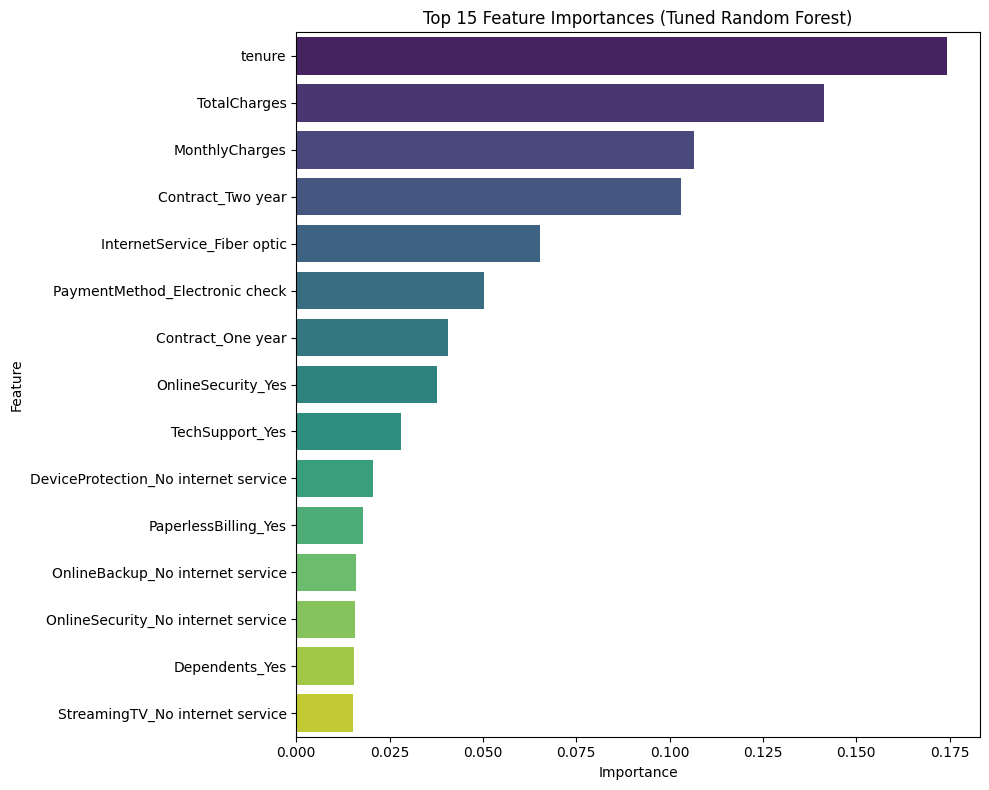


Indices match for X_test_original_for_tableau and X_test. Safe to add predictions.

--- Sample of data prepared for Tableau export (first 5 rows) ---
      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
437     Male              0     Yes        Yes      72          Yes   
2280  Female              1      No         No       8          Yes   
2235  Female              0     Yes        Yes      41          Yes   
4460    Male              0     Yes         No      18          Yes   
3761  Female              0     Yes         No      72          Yes   

     MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
437            Yes     Fiber optic            Yes          Yes  ...   
2280           Yes     Fiber optic             No           No  ...   
2235           Yes             DSL            Yes          Yes  ...   
4460            No     Fiber optic             No           No  ...   
3761           Yes             DSL            Yes          Yes  ...

In [ ]:
# Get feature importances from the tuned Random Forest model
importances = best_rf_model.feature_importances_
feature_names = X_train.columns # X_train has the same columns as X (our feature set)

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\n\n--- Top 15 Feature Importances from Tuned Random Forest ---")
print(feature_importance_df.head(15))

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (Tuned Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- Preparing data for potential Tableau export ---
# Let's add the predictions of our best model to the original (but cleaned) dataframe
# We'll use the test set indices to correctly align predictions.
# First, let's get the original data corresponding to X_test to have interpretable features before encoding.
# We need to be careful here. df_cleaned was before one-hot encoding.
# X_test is already one-hot encoded and scaled.

# For Tableau, you'd typically want to use the original categorical features
# rather than the one-hot encoded ones for easier interpretation.
# So, let's take the original df_cleaned, split it the same way, and add predictions.

# Re-split df_cleaned (data before one-hot encoding but after initial cleaning)
# to get the original features for the test set.
# Ensure it's the version where 'Churn' is 0/1 and 'TotalCharges' is numeric.
# (df_cleaned from end of "Phase 3: Data Cleaning and Preprocessing - Part 1")

# We already have y_test (actual churn) and y_pred_rf_tuned (predicted churn for test set)
# X_test_original_features will be df_cleaned.loc[X_test.index]
# X_test.index contains the original indices from df_cleaned that ended up in the test set.

if 'df_cleaned' not in locals():
    print("Error: df_cleaned is not defined. Please ensure previous steps were run correctly.")
else:
    X_original_features = df_cleaned.drop('Churn', axis=1)
    y_original_target = df_cleaned['Churn']

    _, X_test_original_for_tableau, _, _ = train_test_split(
        X_original_features, y_original_target, test_size=0.2, random_state=42, stratify=y_original_target
    )

    # Ensure indices match before assigning
    if X_test_original_for_tableau.index.equals(X_test.index):
        print("\nIndices match for X_test_original_for_tableau and X_test. Safe to add predictions.")
        # Add actual churn (y_test) and predicted churn (e.g., from tuned RF)
        results_for_tableau = X_test_original_for_tableau.copy()
        results_for_tableau['Actual_Churn'] = y_test # y_test comes from the split of df_encoded, indices should align
        results_for_tableau['Predicted_Churn_RF_Tuned'] = y_pred_rf_tuned

        # Also add predictions from Balanced Logistic Regression for comparison if desired
        results_for_tableau['Predicted_Churn_LR_Balanced'] = y_pred_lr_balanced


        print("\n--- Sample of data prepared for Tableau export (first 5 rows) ---")
        print(results_for_tableau.head())

        # You would then export this to CSV for Tableau:
        # results_for_tableau.to_csv('churn_predictions_for_tableau.csv', index=False)
        print("\nTo export for Tableau, you would uncomment and run: results_for_tableau.to_csv('churn_predictions_for_tableau.csv', index=False)")
    else:
        print("\nIndex mismatch. Cannot reliably add predictions to original features for Tableau this way.")
        print("This can happen if df_cleaned was modified or not the correct version from after 'TotalCharges' fix and 'Churn' to 0/1.")
        print("For Tableau, you'd need the original df rows that correspond to X_test.index.")
        # Fallback: you can use X_test (encoded) and add predictions if above fails.
        # X_test_with_preds = X_test.copy()
        # X_test_with_preds['Actual_Churn'] = y_test
        # X_test_with_preds['Predicted_Churn_RF_Tuned'] = y_pred_rf_tuned
        # print(X_test_with_preds.head())



--- SHAP Feature Importance Analysis ---
Initializing SHAP TreeExplainer...
Calculating SHAP values for the test set (this might take a moment)...
SHAP values calculated.

Generating SHAP Summary Plot (Beeswarm)...


<Figure size 1000x800 with 0 Axes>

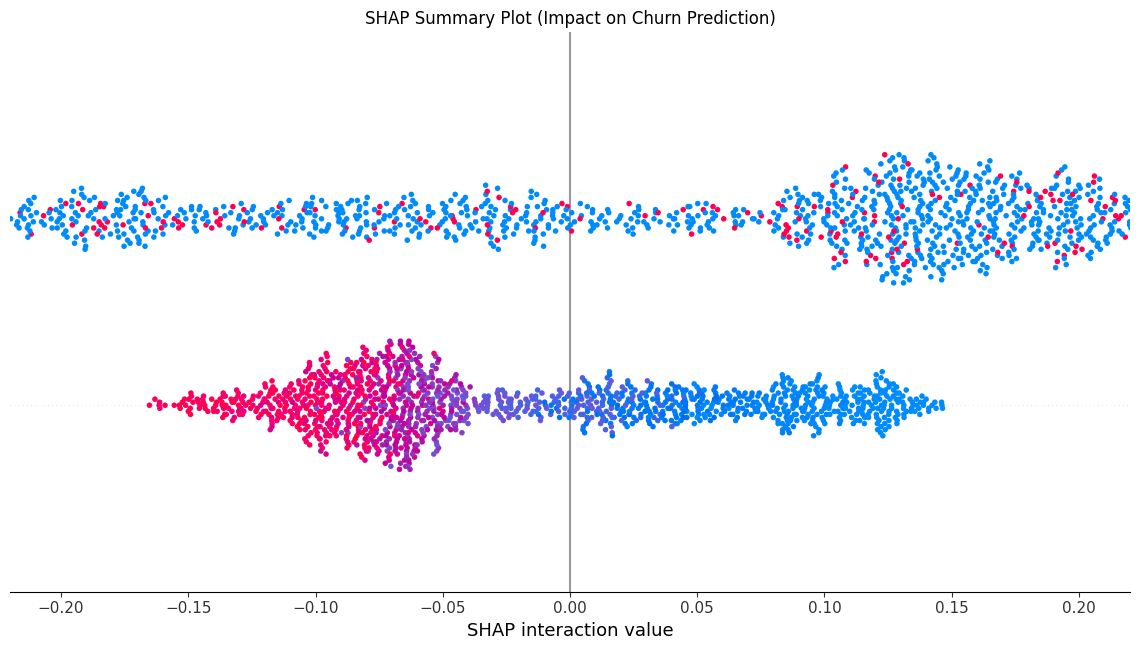


Generating SHAP Global Feature Importance (Bar Plot)...


<Figure size 1000x800 with 0 Axes>

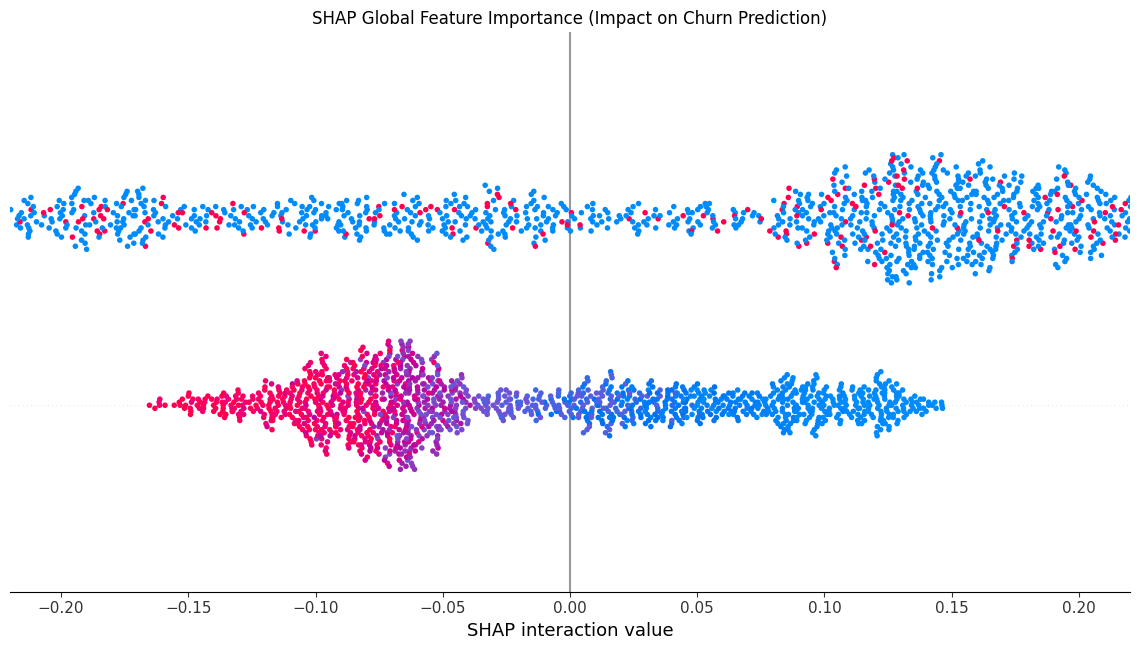


--- How to Interpret the SHAP Summary (Beeswarm) Plot ---
1. Features are ranked by the sum of absolute SHAP values across all samples (most important at the top).
2. Each point on the plot is a single prediction (a customer in your X_test).
3. The horizontal position of the point shows the impact of that feature on the model's output for that prediction.
   - Positive SHAP values: Push the prediction towards Churn (1).
   - Negative SHAP values: Push the prediction away from Churn (towards No Churn, 0).
4. The color of the point indicates the feature's value for that specific customer:
   - Red points: Represent high values of the feature.
   - Blue points: Represent low values of the feature.
   - A vertical spread of red and blue points for a feature indicates an interaction effect with other features.
For example, if 'tenure' is at the top:
  - You might see many blue points (low tenure) on the right (positive SHAP value), suggesting low tenure increases churn likelihood.
  - You 

In [ ]:
import shap

# Ensure X_test is available and has the same features as X_train used for model training
# The model 'best_rf_model' was trained on X_train (scaled and one-hot encoded)
# So, we will use X_test for SHAP values.

print("\n\n--- SHAP Feature Importance Analysis ---")
print("Initializing SHAP TreeExplainer...")
# For tree-based models like Random Forest, TreeExplainer is efficient.
explainer = shap.TreeExplainer(best_rf_model) # 'best_rf_model' is our tuned Random Forest

print("Calculating SHAP values for the test set (this might take a moment)...")
# It's often recommended to use a subset of data for SHAP values if the dataset is very large,
# but X_test (1409 samples) should be manageable.
shap_values = explainer.shap_values(X_test)
print("SHAP values calculated.")

# For binary classification with Random Forest in scikit-learn,
# explainer.shap_values(X) returns a list of two arrays (one for each class).
# We are interested in the SHAP values for the "Churn" class (class 1).
# The output of shap_values might be a list of two arrays (for class 0 and class 1)
# or a single array if the explainer handles it.
# For scikit-learn binary classifiers, shap_values will be a list [shap_values_class_0, shap_values_class_1]
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_for_churn_class = shap_values[1] # Values for the positive class (Churn=1)
else: # Should not happen for RandomForestClassifier but as a fallback
    shap_values_for_churn_class = shap_values


# --- SHAP Summary Plot (Beeswarm) ---
# This plot shows the SHAP values for each feature for every sample.
# - Each dot is a customer in the X_test set.
# - The color of the dot represents the feature's value for that customer (Red=High, Blue=Low).
# - The position on the x-axis is the SHAP value, indicating how much that feature's value
#   pushed the model's output for that customer (positive SHAP values push towards Churn=1).
print("\nGenerating SHAP Summary Plot (Beeswarm)...")
plt.figure(figsize=(10,8)) # Adjust figure size if needed
shap.summary_plot(shap_values_for_churn_class, X_test, plot_type="beeswarm", show=False)
plt.title("SHAP Summary Plot (Impact on Churn Prediction)")
plt.tight_layout()
plt.show()


# --- Global Feature Importance from SHAP ---
# This is derived by taking the mean absolute SHAP value for each feature across all samples.
print("\nGenerating SHAP Global Feature Importance (Bar Plot)...")
plt.figure(figsize=(10,8)) # Adjust figure size if needed
shap.summary_plot(shap_values_for_churn_class, X_test, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (Impact on Churn Prediction)")
plt.tight_layout()
plt.show()

# Explanation of SHAP Summary (Beeswarm) Plot:
print("\n--- How to Interpret the SHAP Summary (Beeswarm) Plot ---")
print("1. Features are ranked by the sum of absolute SHAP values across all samples (most important at the top).")
print("2. Each point on the plot is a single prediction (a customer in your X_test).")
print("3. The horizontal position of the point shows the impact of that feature on the model's output for that prediction.")
print("   - Positive SHAP values: Push the prediction towards Churn (1).")
print("   - Negative SHAP values: Push the prediction away from Churn (towards No Churn, 0).")
print("4. The color of the point indicates the feature's value for that specific customer:")
print("   - Red points: Represent high values of the feature.")
print("   - Blue points: Represent low values of the feature.")
print("   - A vertical spread of red and blue points for a feature indicates an interaction effect with other features.")
print("For example, if 'tenure' is at the top:")
print("  - You might see many blue points (low tenure) on the right (positive SHAP value), suggesting low tenure increases churn likelihood.")
print("  - You might see many red points (high tenure) on the left (negative SHAP value), suggesting high tenure decreases churn likelihood.")

# Further SHAP analysis you could do (optional for now):
# shap.dependence_plot("feature_name", shap_values_for_churn_class, X_test)
# This shows how a single feature's value affects its SHAP value (and thus the prediction),
# and can also show interaction effects with another feature (color-coded).

In [ ]:
import numpy as np
import pandas as pd
import shap # Ensure shap is imported

# --- Prerequisites (ensure these are defined from previous notebook cells) ---
# X_test: Your scaled and one-hot encoded test features (Pandas DataFrame)
# best_rf_model: Your trained and tuned RandomForestClassifier model

if 'X_test' not in locals() or 'best_rf_model' not in locals():
    print("ERROR: 'X_test' or 'best_rf_model' is not defined. Please re-run the cells for:")
    print("1. Data splitting (train_test_split) and scaling (StandardScaler) to get X_test.")
    print("2. Hyperparameter tuning (GridSearchCV) to get best_rf_model.")
else:
    print("Found 'X_test' and 'best_rf_model'. Proceeding to redefine dependent SHAP variables...")

    print("\n1. Preparing X_test_for_plot (converting boolean columns to integers)...")
    X_test_for_plot = X_test.copy()
    converted_cols_count = 0
    for col in X_test_for_plot.columns:
        if X_test_for_plot[col].dtype == 'bool':
            X_test_for_plot[col] = X_test_for_plot[col].astype(int)
            converted_cols_count += 1
    if converted_cols_count > 0:
        print(f"Converted {converted_cols_count} boolean columns to int in X_test_for_plot.")
    else:
        print("No boolean columns found/converted in X_test_for_plot (possibly already int).")
    # X_test_for_plot.info(verbose=False) # Optional: check dtypes

    print("\n2. Initializing SHAP TreeExplainer...")
    try:
        explainer = shap.TreeExplainer(best_rf_model)
        print("SHAP TreeExplainer initialized.")

        print("\n3. Calculating raw SHAP values (can take a moment)...")
        # This will likely be a 3D array for binary classification with scikit-learn RF
        raw_shap_values = explainer.shap_values(X_test)
        print(f"Raw SHAP values calculated. Shape: {np.array(raw_shap_values).shape}") # Use np.array for consistent shape attribute

        print("\n4. Extracting SHAP values for the 'Churn' class (class 1)...")
        # If raw_shap_values is a list of two arrays [class0_shap, class1_shap]
        if isinstance(raw_shap_values, list) and len(raw_shap_values) == 2:
            shap_values_churn_2d = raw_shap_values[1]
        # If raw_shap_values is a 3D numpy array [samples, features, classes]
        elif isinstance(raw_shap_values, np.ndarray) and raw_shap_values.ndim == 3 and raw_shap_values.shape[-1] == 2:
            shap_values_churn_2d = raw_shap_values[:, :, 1]
        else:
            # Fallback or error if the structure is unexpected
            print("WARNING: Unexpected structure for raw_shap_values. Attempting to use as is or adjust if common single output.")
            # This case needs to be handled based on actual output of explainer.shap_values
            # For now, assuming it's one of the above two common cases for binary classification.
            # If it's a single 2D array (e.g. if model output was a single decision_function)
            # then shap_values_churn_2d = raw_shap_values would be used, but this is less common for RF predict_proba
            shap_values_churn_2d = None # Needs to be correctly assigned based on raw_shap_values structure
            raise ValueError(f"Unexpected raw_shap_values structure: {type(raw_shap_values)}, shape: {np.array(raw_shap_values).shape if hasattr(raw_shap_values, 'shape') else 'N/A'}")


        if shap_values_churn_2d is not None:
            print(f"SHAP values for churn class extracted. Shape: {shap_values_churn_2d.shape}")

            print("\n5. Getting base value for the 'Churn' class...")
            base_value_for_churn_class = explainer.expected_value
            if isinstance(base_value_for_churn_class, (list, np.ndarray)) and len(base_value_for_churn_class) == 2:
                base_value_for_churn_class = base_value_for_churn_class[1]
                print(f"Using base value for churn class: {base_value_for_churn_class}")
            else:
                print(f"Warning: explainer.expected_value is {base_value_for_churn_class}. Using as is.")


            print("\n6. Creating shap.Explanation object...")
            explanation_object = shap.Explanation(
                values=shap_values_churn_2d,
                base_values=base_value_for_churn_class,
                data=X_test_for_plot.values, # Feature values as a NumPy array
                feature_names=X_test_for_plot.columns.tolist()
            )
            print("Successfully created shap.Explanation object.")
            print(f"Explanation object type: {type(explanation_object)}")
            print("You can now re-run the SHAP plotting code.")

        else:
            print("ERROR: shap_values_churn_2d was not correctly extracted. Cannot create Explanation object.")

    except Exception as e:
        print(f"An error occurred during re-definition: {e}")
        print("Please ensure 'X_test' and 'best_rf_model' are correctly defined and SHAP is installed.")

Found 'X_test' and 'best_rf_model'. Proceeding to redefine dependent SHAP variables...

1. Preparing X_test_for_plot (converting boolean columns to integers)...
Converted 26 boolean columns to int in X_test_for_plot.

2. Initializing SHAP TreeExplainer...
SHAP TreeExplainer initialized.

3. Calculating raw SHAP values (can take a moment)...
Raw SHAP values calculated. Shape: (1409, 30, 2)

4. Extracting SHAP values for the 'Churn' class (class 1)...
SHAP values for churn class extracted. Shape: (1409, 30)

5. Getting base value for the 'Churn' class...
Using base value for churn class: 0.49961140744085586

6. Creating shap.Explanation object...
Successfully created shap.Explanation object.
Explanation object type: <class 'shap._explanation.Explanation'>
You can now re-run the SHAP plotting code.


--- 1. SHAP Global Feature Importance (Bar Plot) ---


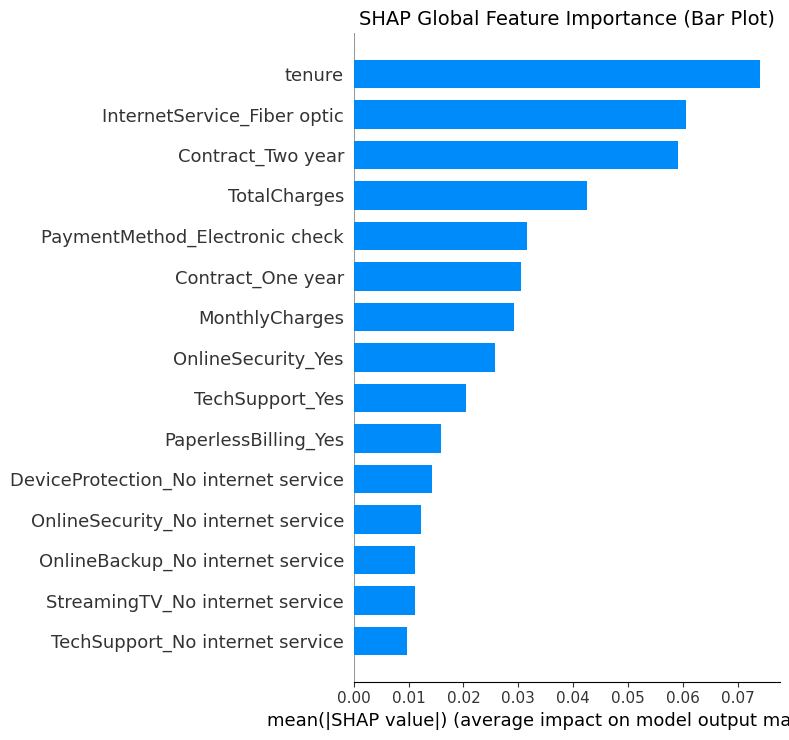


--- 2. SHAP Violin Plot (Alternative/Confirmation for Detailed Impact) ---


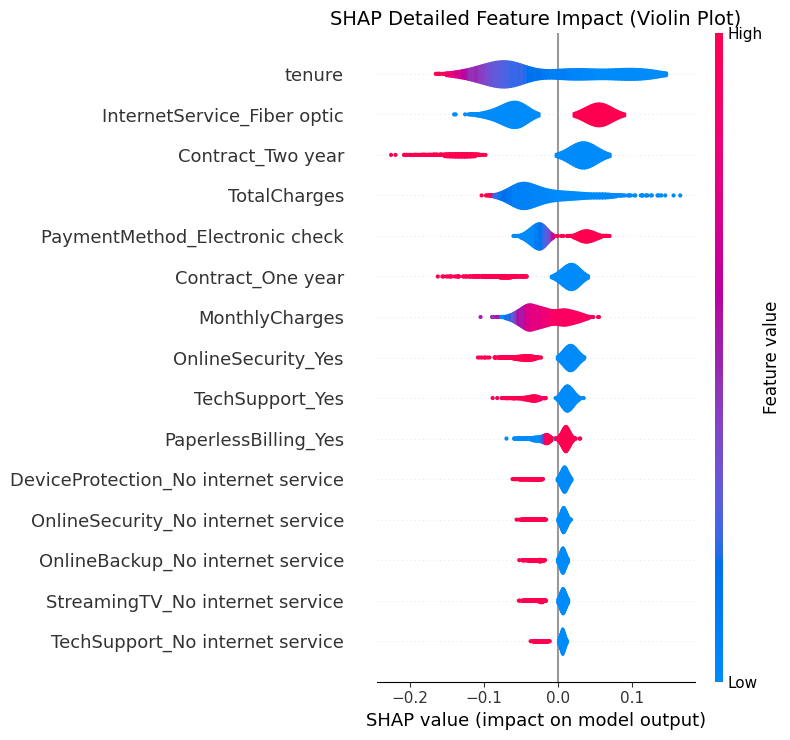


--- 3. SHAP Dependence Plots (for top features) ---

Generating SHAP Dependence Plot for: tenure


<Figure size 640x480 with 0 Axes>

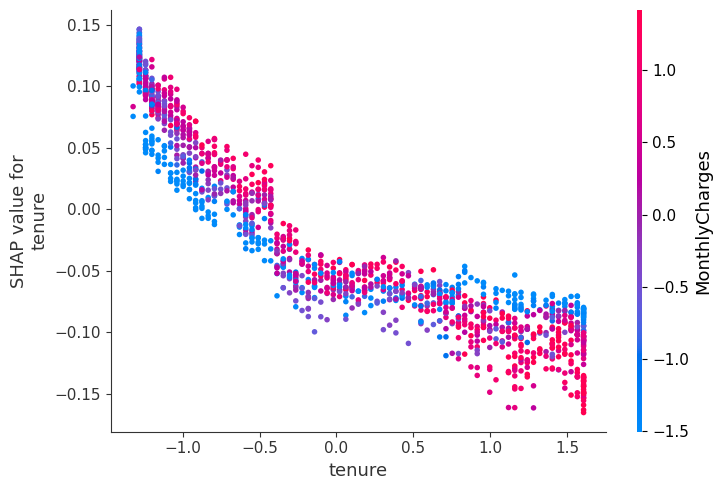


Generating SHAP Dependence Plot for: InternetService_Fiber optic


<Figure size 640x480 with 0 Axes>

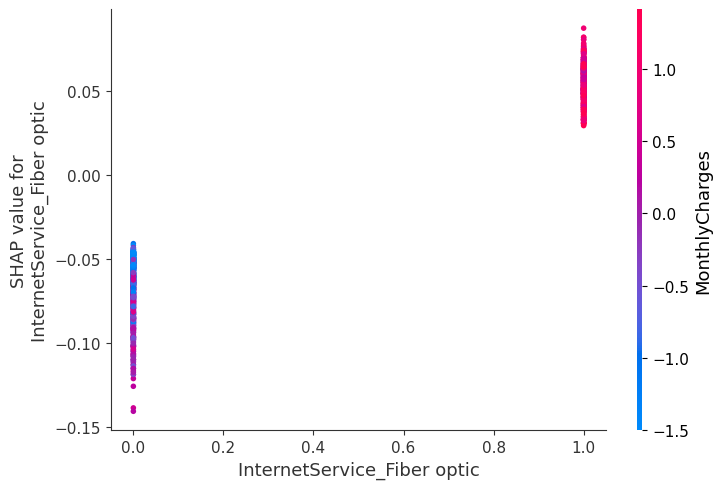


Generating SHAP Dependence Plot for: Contract_Two year


<Figure size 640x480 with 0 Axes>

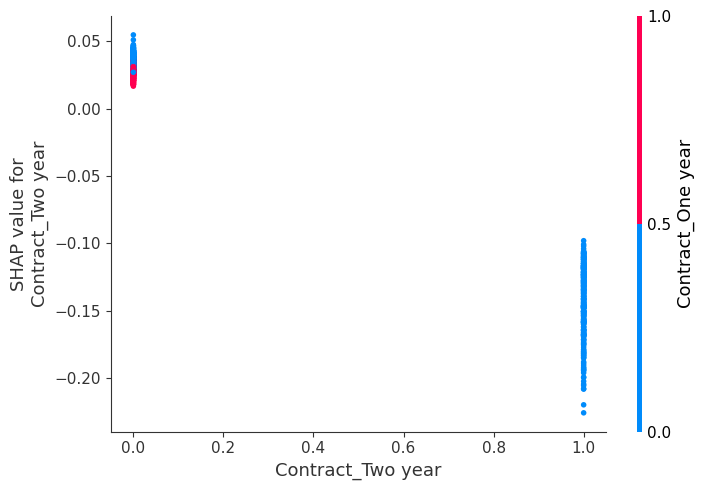

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd # ensure pandas is imported for X_test_for_plot if not already

# Ensure 'explanation_object' is defined from the previous step,
# and X_test_for_plot (DataFrame with bools as int) is also available.

if 'explanation_object' in locals() and 'X_test_for_plot' in locals():
    print("--- 1. SHAP Global Feature Importance (Bar Plot) ---")
    plt.figure(figsize=(10, 8)) # Create a new figure context
    try:
        shap.summary_plot(
            explanation_object,
            plot_type="bar",
            max_display=15, # Show top 15 features
            show=False
        )
        plt.title("SHAP Global Feature Importance (Bar Plot)", fontsize=14)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating SHAP bar plot: {e}")


    print("\n--- 2. SHAP Violin Plot (Alternative/Confirmation for Detailed Impact) ---")
    # We know this was working with X_test_for_plot before, should also work with Explanation obj.
    plt.figure(figsize=(12, 8)) # Create a new figure context
    try:
        shap.summary_plot(
            explanation_object,
            plot_type="violin",
            max_display=15,
            show=False
        )
        plt.title("SHAP Detailed Feature Impact (Violin Plot)", fontsize=14)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating SHAP violin plot: {e}")


    print("\n--- 3. SHAP Dependence Plots (for top features) ---")
    # Dependence plots show how a single feature's value affects its SHAP value.
    # It can also automatically show interaction effects with another feature.

    # First, let's get a list of features sorted by global importance (mean absolute SHAP value)
    mean_abs_shap = np.abs(explanation_object.values).mean(0)
    # Create a DataFrame for sorting
    shap_importance_df = pd.DataFrame({
        'feature': explanation_object.feature_names,
        'mean_abs_shap': mean_abs_shap
    })
    shap_importance_df = shap_importance_df.sort_values(by='mean_abs_shap', ascending=False)
    top_features = shap_importance_df['feature'].tolist()

    # Plot dependence for the top 2-3 features
    for i in range(min(3, len(top_features))): # Plot for up to 3 top features
        feature_to_plot = top_features[i]
        print(f"\nGenerating SHAP Dependence Plot for: {feature_to_plot}")
        plt.figure() # Create a new figure context for each dependence plot
        try:
            # For shap.dependence_plot, we pass the feature *name* or *index*
            # and the full SHAP values array (for the class of interest) and feature values DataFrame
            shap.dependence_plot(
                feature_to_plot,
                explanation_object.values, # The 2D SHAP values for the churn class
                features=X_test_for_plot,  # The DataFrame with feature values
                interaction_index="auto",  # SHAP will try to pick an interaction feature
                show=False
            )
            # The title is often automatically generated by dependence_plot to include interaction feature
            # plt.title(f"SHAP Dependence Plot for {feature_to_plot}", fontsize=14)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error generating SHAP dependence plot for {feature_to_plot}: {e}")
else:
    print("ERROR: 'explanation_object' or 'X_test_for_plot' is not defined. Please ensure previous steps were successful.")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split # Just for reference to where X_test came from
# We assume df_cleaned, df_encoded, X, y, X_train, X_test, y_train, y_test have been defined
# and best_rf_model is also defined from your Phase 8 run.

# --- Safety Check for df_cleaned ---
if 'df_cleaned' not in locals():
    print("ERROR: 'df_cleaned' is not defined. Please re-run data loading and initial cleaning steps (Phases 1-3 Part 1).")
    print("       'df_cleaned' should be the DataFrame before one-hot encoding, but after TotalCharges fix and Churn to 0/1.")
# --- Safety Check for X_test (scaled and encoded) ---
elif 'X_test' not in locals() or not hasattr(X_test, 'index'):
    print("ERROR: 'X_test' (scaled and encoded, with an index) is not defined.")
    print("       Please re-run data splitting and scaling steps (Phases 4 & 5).")
else:
    print("Defining 'X_test_original_for_tableau' using df_cleaned and X_test.index...")
    try:
        # X_test.index carries the original indices from df_encoded, which trace back to df_cleaned
        X_test_original_for_tableau = df_cleaned.loc[X_test.index]
        print("'X_test_original_for_tableau' defined successfully.")
        print(f"Shape of X_test_original_for_tableau: {X_test_original_for_tableau.shape}")
        print("Sample of X_test_original_for_tableau:")
        print(X_test_original_for_tableau.head())
    except KeyError as e:
        print(f"KeyError defining X_test_original_for_tableau: {e}")
        print("This might happen if the indices in X_test do not exist in df_cleaned.")
        print("Ensure df_cleaned is from the correct stage and X_test was derived correctly.")
    except Exception as e:
        print(f"An error occurred defining X_test_original_for_tableau: {e}")

Defining 'X_test_original_for_tableau' using df_cleaned and X_test.index...
'X_test_original_for_tableau' defined successfully.
Shape of X_test_original_for_tableau: (1409, 20)
Sample of X_test_original_for_tableau:
      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
437     Male              0     Yes        Yes      72          Yes   
2280  Female              1      No         No       8          Yes   
2235  Female              0     Yes        Yes      41          Yes   
4460    Male              0     Yes         No      18          Yes   
3761  Female              0     Yes         No      72          Yes   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
437            Yes     Fiber optic            Yes          Yes   
2280           Yes     Fiber optic             No           No   
2235           Yes             DSL            Yes          Yes   
4460            No     Fiber optic             No           No   
3761           Yes         

In [ ]:
import pandas as pd # Ensure pandas is imported

# --- Prerequisites from your script ---
# X_test_original_for_tableau: DataFrame with original features for test set customers.
# y_test: Actual churn labels for the test set (Pandas Series or NumPy array).
# best_rf_model: Your tuned Random Forest model object (from GridSearchCV).
# X_test: Your scaled and one-hot encoded test features (used by best_rf_model for predictions).
# y_pred_rf_tuned: Predictions from best_rf_model.

# Verify necessary variables are available
if 'X_test_original_for_tableau' not in locals() or \
   'y_test' not in locals() or \
   'best_rf_model' not in locals() or \
   'X_test' not in locals() or \
   'y_pred_rf_tuned' not in locals():
    print("ERROR: One or more required variables for creating 'results_for_tableau.csv' are not defined.")
    print("Please ensure the cell that defines X_test_original_for_tableau, y_test, X_test,")
    print("and performs GridSearchCV for Random Forest (defining best_rf_model and y_pred_rf_tuned) has been successfully run.")
else:
    print("Preparing customer-level data for Tableau using the Tuned Random Forest model...")

    # Get churn probabilities from the Tuned Random Forest model
    y_proba_rf_tuned = best_rf_model.predict_proba(X_test)[:, 1] # Probability of churn (class 1)

    # Create the results DataFrame
    results_for_tableau = X_test_original_for_tableau.copy()

    # Add actual churn values
    # Ensuring y_test is aligned with the index of results_for_tableau
    if isinstance(y_test, pd.Series):
        results_for_tableau['Actual_Churn'] = y_test.values # Use .values if index might mismatch but order is correct
    else: # Assuming y_test is a NumPy array in correct order
        results_for_tableau['Actual_Churn'] = y_test

    results_for_tableau['Predicted_Churn_TunedRF'] = y_pred_rf_tuned
    results_for_tableau['Churn_Probability_TunedRF'] = y_proba_rf_tuned

    print("\nSample of 'results_for_tableau' DataFrame (first 5 rows):")
    print(results_for_tableau.head())

    # Export to CSV
    try:
        results_for_tableau.to_csv('churn_predictions_for_tableau.csv', index=False)
        print("\nSuccessfully exported 'churn_predictions_for_tableau.csv'")
    except Exception as e:
        print(f"\nError exporting 'churn_predictions_for_tableau.csv': {e}")

Preparing customer-level data for Tableau using the Tuned Random Forest model...

Sample of 'results_for_tableau' DataFrame (first 5 rows):
      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
437     Male              0     Yes        Yes      72          Yes   
2280  Female              1      No         No       8          Yes   
2235  Female              0     Yes        Yes      41          Yes   
4460    Male              0     Yes         No      18          Yes   
3761  Female              0     Yes         No      72          Yes   

     MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
437            Yes     Fiber optic            Yes          Yes  ...   
2280           Yes     Fiber optic             No           No  ...   
2235           Yes             DSL            Yes          Yes  ...   
4460            No     Fiber optic             No           No  ...   
3761           Yes             DSL            Yes          Yes  ...   

     S

In [ ]:
import pandas as pd
import numpy as np # Ensure numpy is imported

# --- Prerequisites for SHAP importances ---
# explanation_object: Your SHAP Explanation object created from best_rf_model and X_test_for_plot
# X_test_for_plot: DataFrame used for SHAP (bools converted to int)

# --- Prerequisites for RF default importances (Fallback) ---
# best_rf_model: Your tuned Random Forest model object
# X_train.columns: Column names from your training data (matching features model was trained on)


# Option 1: Using SHAP Global Feature Importances (Preferred)
if 'explanation_object' in locals() and hasattr(explanation_object, 'values') and hasattr(explanation_object, 'feature_names'):
    print("\nPreparing global SHAP feature importance data for Tableau...")
    mean_abs_shap_values = np.abs(explanation_object.values).mean(0)

    shap_importance_df_for_export = pd.DataFrame({
        'Feature': explanation_object.feature_names,
        'Global_SHAP_Importance': mean_abs_shap_values
    })
    shap_importance_df_for_export = shap_importance_df_for_export.sort_values(
        by='Global_SHAP_Importance', ascending=False
    )

    print("\nSample of 'global_shap_importances_for_tableau' DataFrame (top 10 features):")
    print(shap_importance_df_for_export.head(10))

    try:
        shap_importance_df_for_export.to_csv('global_shap_feature_importances.csv', index=False)
        print("\nSuccessfully exported 'global_shap_feature_importances.csv'")
    except Exception as e:
        print(f"\nError exporting 'global_shap_feature_importances.csv': {e}")

# Option 2: Fallback to Random Forest Default Feature Importances
elif 'best_rf_model' in locals() and 'X_train' in locals() and hasattr(X_train, 'columns'):
    print("\nSHAP 'explanation_object' not found. Falling back to Random Forest default feature importances...")
    importances_rf_default = best_rf_model.feature_importances_
    feature_names_rf_default = X_train.columns # Features model was trained on

    rf_default_importance_df = pd.DataFrame({
        'Feature': feature_names_rf_default,
        'RF_Default_Importance': importances_rf_default
    })
    rf_default_importance_df = rf_default_importance_df.sort_values(
        by='RF_Default_Importance', ascending=False
    )

    print("\nSample of 'rf_default_feature_importances_for_tableau' DataFrame (top 10 features):")
    print(rf_default_importance_df.head(10))

    try:
        rf_default_importance_df.to_csv('rf_default_feature_importances.csv', index=False)
        print("\nSuccessfully exported 'rf_default_feature_importances.csv'")
    except Exception as e:
        print(f"\nError exporting 'rf_default_feature_importances.csv': {e}")
else:
    print("\nCould not generate feature importances: Necessary variables (SHAP 'explanation_object' or 'best_rf_model'/'X_train') are missing.")


Preparing global SHAP feature importance data for Tableau...

Sample of 'global_shap_importances_for_tableau' DataFrame (top 10 features):
                           Feature  Global_SHAP_Importance
1                           tenure                0.073977
10     InternetService_Fiber optic                0.060629
25               Contract_Two year                0.059092
3                     TotalCharges                0.042522
28  PaymentMethod_Electronic check                0.031656
24               Contract_One year                0.030432
2                   MonthlyCharges                0.029257
13              OnlineSecurity_Yes                0.025805
19                 TechSupport_Yes                0.020444
26            PaperlessBilling_Yes                0.015905

Successfully exported 'global_shap_feature_importances.csv'
